In [1]:
import numpy as np
import pandas as pd
import math
import emcee
import numpy.random as rand
import scipy
from emcee import PTSampler
from scipy.stats import binom as binomial
from scipy.stats import gamma
import matplotlib.pyplot as plt
import corner
from scipy.stats import norm
from ipywidgets import FloatProgress
from IPython.display import display
import sys
import pickle
import PTMCMCSampler
from PTMCMCSampler import PTMCMCSampler as ptmcmc
from scipy.stats import beta as betafunction
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)




In [2]:

def inv_logit(p):
    return np.exp(p) / (1. + np.exp(p))

#Proposal to return veff to prior
def veffprop(x,iter,beta):
    q = x.copy()
    qxy = 0.
    
    q[6] = np.random.normal(0.75,0.01)
    qxy = scipy.stats.norm.pdf(q[6],0.75,0.1)
    #if iter<20000:
     #   q[6] = 0.8
    if iter>40000:
        qxy = 1.
        q = x.copy()
    return q, qxy

class LikelihoodWrapper(object):
    """Wrapper for likelihood function.
        
        :param likelihood: Likelihood function that reads in parameter vector x and iteration
        """
            
    def __init__(self, likelihood):
        self.likelihood = likelihood
        self.iter = 0
    
    def __call__(self, x):
        ret = self.likelihood(x, self.iter)
        self.iter += 1
        return ret



    

In [106]:
#Real data, read in with Pandas.
vobs_pandas = pd.read_csv('../newdata/Xvax.csv')
vtrials_pandas = pd.read_csv('../newdata/Nvax.csv')
sobs_pandas = pd.read_csv('../newdata/YseroNew.csv')
strials_pandas = pd.read_csv('../newdata/NseroNew.csv')
cases_pandas = pd.read_csv('../newdata/reported_cases_all.csv')

#Select the locations you want to work with
#loc_subset = ['KINSHASA','EQUATEUR','MANIEMA','ORIENTALE','BANDUNDU', 'BAS-CONGO', 'KASAI-OCCIDENTAL', 'KASAI-ORIENTAL',
#           'KATANGA', 'NORD-KIVU', 'SUD-KIVU' ]
#FIX ME: Why is itonly loading in these six places?
loc_subset = ['BANDUNDU']
vobs = vobs_pandas.loc[:,loc_subset]
vtrial = vtrials_pandas.loc[:,loc_subset]
sobs = sobs_pandas.loc[:,loc_subset]
strial = strials_pandas.loc[:,loc_subset]
cases = cases_pandas.loc[:,loc_subset]

#Convert to numpy arrays
vo = vobs.values
vt = vtrial.values
so = sobs.values
st = strial.values
co = cases.values

vo = np.sum(vo,axis=-1)
vt = np.sum(vt,axis=-1)
so = np.sum(so,axis=-1)
st = np.sum(st,axis=-1)
co = np.sum(co,axis=-1)

vobs = np.copy(vo)
vtry = np.copy(vt)
sobs = np.copy(so)
stry = np.copy(st)
cobs = np.copy(co)

print np.shape(vo)

(60,)


In [107]:
#Read in and process data from simulation
'''
Data_pd = pd.read_csv("FakeData50.csv",header=None)
Data = Data_pd.as_matrix()
vo = Data[:,0].copy()
vt = Data[:,1].copy()
so = Data[:,2].copy()
st = Data[:,3].copy()
cobs = Data[:,4].copy()

vobs = vo.copy()
vtry = vt.copy()
sobs = so.copy()
stry = st.copy()
'''

'\nData_pd = pd.read_csv("FakeData50.csv",header=None)\nData = Data_pd.as_matrix()\nvo = Data[:,0].copy()\nvt = Data[:,1].copy()\nso = Data[:,2].copy()\nst = Data[:,3].copy()\ncobs = Data[:,4].copy()\n\nvobs = vo.copy()\nvtry = vt.copy()\nsobs = so.copy()\nstry = st.copy()\n'

In [109]:
'''
vo = Data[:,-9].copy()
vt = Data[:,2].copy()
so = Data[:,3].copy()
st = Data[:,4].copy()
cobs = Data[:,5].copy()
vobs = vo.copy()
vtry = vt.copy()
sobs = so.copy()
stry = st.copy()
'''


'\nvo = Data[:,-9].copy()\nvt = Data[:,2].copy()\nso = Data[:,3].copy()\nst = Data[:,4].copy()\ncobs = Data[:,5].copy()\nvobs = vo.copy()\nvtry = vt.copy()\nsobs = so.copy()\nstry = st.copy()\n'

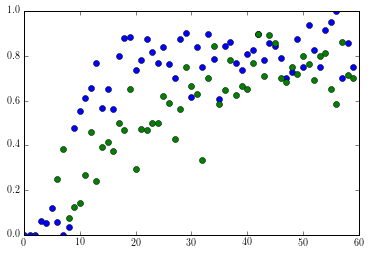

In [111]:
total_cases = np.sum(cobs[:])

plt.plot(vobs.astype(float)/vtry.astype(float),'bo')
plt.plot(sobs.astype(float)/stry.astype(float),'go')
#plt.plot(cobs[:].astype(float)/total_cases,'r')
#plt.savefig("NKIVU-data.pdf")

In [43]:
#Now define the prior and likelihood:

def logltest(x,iter):
    return 0.0

def logl(x,iter): #The model to be extracted is pmeas_i * Data[i]
    lnlike = 0.
    N = len(vobs)
    
    #Parameters
    valpha = va = x[0]
    vbeta = vb = x[1]
    vheight = vh = x[2]
    falpha = fa =x[3]
    fbeta = fb = x[4]
    fheight = fh =x[5]
    
    
    if iter<-10:
        x[6] = 0.55
    
    #x[6] = 0.0
    veff = ve = x[6]
    x[7] = 0.
    c = x[7]
    
    vprob = np.zeros(N)
    sprob = np.zeros(N)
    cprob = np.zeros(N)
    for i in range(0,N):
        a = float(i+1.)
        vprob[i] = 1. - np.exp(-vh*(1. - np.exp(-(a/vb)**va)))
        sprob[i] = 1. - np.exp(-vh*ve*(1. - np.exp(-(a/vb)**va)) - fh*(1. - np.exp(-(a/fb)**fa)))
        cprob[i] = (1.-np.exp(-fh*(fa/fb)*(a*12./fb)**(fa-1.)*np.exp(-(a*12./fb)**fa)))*\
                                       (np.exp(-ve*vh*(1.-np.exp(-(a*12./vb)**va))-fh*(1.-np.exp(-(a*12./fb)**fa))))
        if vprob[i] < 0.0:
            #print vprob
            return -np.inf
        if sprob[i] < 0.0:
            #print sprob
            return -np.inf
        
        lnlike += np.log(binomial.pmf(vobs[i],vtry[i],vprob[i]))
        lnlike += np.log(binomial.pmf(sobs[i],stry[i],sprob[i]))
        #lnlike += 0.
   
    cprob /= sum(cprob[:]) 
    lnlike += scipy.stats.multinomial.logpmf(cobs[:],total_cases,cprob[:])
    return lnlike



def lnprior(x):
    logp = 0.
    
    valpha = x[0]
    vbeta = x[1]
    vheight = x[2]
    falpha = x[3]
    fbeta = x[4]
    fheight = x[5]
    veff = x[6]    

    logp += np.log(gamma.pdf(valpha,a=2.,scale=5.))
    logp += np.log(gamma.pdf(vbeta,a=2.,scale=500.))
    logp += np.log(gamma.pdf(vheight,a=2.,scale=15.))
    
    logp += np.log(gamma.pdf(falpha,a=2.,scale=5.))
    logp += np.log(gamma.pdf(fbeta,a=2.,scale=500.))
    logp += np.log(gamma.pdf(fheight,a=2.,scale=15.))
    
    #logp += np.log(scipy.stats.beta.pdf(veff,a=75.,b=25.))
    #logp += np.log(scipy.stats.beta.pdf(veff,a=85.,b=15.)) #Strict
    #logp += np.log(scipy.stats.beta.pdf(veff,a=35.,b=8.))
    logp += np.log(scipy.stats.beta.pdf(veff,a=16.,b=5.))  #Moderate
    #logp += np.log(scipy.stats.beta.pdf(veff,a=1.,b=1.))   #Flat prior
    
    return logp



In [44]:
#Set up walkers
ndim = 8
ntemps = 4

#Set up initial point
p0PT = np.random.uniform(low=0.0, high=1.0, size=(ntemps, 1, ndim))
p0PT = np.array(p0PT)
x0 = np.copy(p0PT[0,0,:])
x0[6] = 7.
x0[7] = 15.
x0[3] = 1.68
x0[4] = 0.2
print np.shape(p0PT)

x0[0] = 7.
x0[1] = 14.2
x0[2] = 1.645
x0[3] = 2.
x0[4] = 200.
x0[5] = 0.5
x0[6] = 0.8
x0[7] = 0.0



(4, 1, 8)


In [45]:
#Test the likelihood call
logl(x0,1)


-533.64650358651693

In [34]:
#Need an initial covariance matrix for this sampler
cov_diag = np.ones(ndim)
cov_diag *= p0PT[0,0,:]*0.5

like = LikelihoodWrapper(logl)

sampler = ptmcmc.PTSampler(int(ndim), like, lnprior, cov=np.diag(cov_diag), groups=None, 
                           outDir='./chains/', verbose=True, resume=False)
sampler.addProposalToCycle(veffprop,1)

NameError: name 'ndim' is not defined

In [49]:
sampler.sample(p0=x0, Niter=int(15.e4), thin=20,
                covUpdate=10000, AMweight=15,
                SCAMweight=25, DEweight=50,
                writeHotChains=False)

0
Finished 6.67 percent in 458.948561 s Acceptance rate = 0.3771Adding DE jump with weight 50
Finished 99.33 percent in 6369.639840 s Acceptance rate = 0.316148
Run Complete


In [87]:
samples_vc = []
i = 0
burnin = 2000
for line in open('chains/DRCLab/nosero/ORIENTALE/chain_1.txt','r'):
    sample_nc = line.split()
    if i> burnin:
        samples_vc.append(sample_nc)
    i += 1

In [45]:
samples_vs = []
i = 0
burnin = 3000
for line in open('chains/DRCALL/nocase/KATANGA/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples_vs.append(sample)
    i += 1

In [46]:
samples_nc = np.array(samples_nc)
samples_nc = samples_nc.astype(float)
print len(samples_nc)

samples = np.array(samples)
samples = samples.astype(float)
print len(samples)

NameError: name 'samples_nc' is not defined

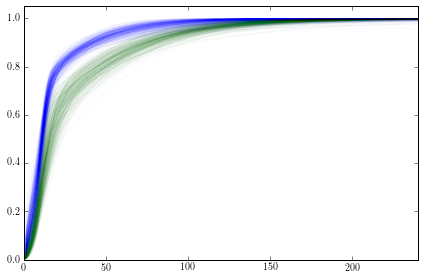

In [63]:
nspace = 20*12*10
x = np.linspace(1,20*12,nspace)
splotnc = np.zeros(nspace)
splot = np.zeros(nspace)
foi = np.zeros(nspace)
l = len(samples[:,0])
nplot = 500
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
#ax0 = axes
#ax0, ax1, ax2 = axes.flatten()
#ax0, ax1 = axes.flatten()
for k in range(nplot):
    index = np.random.randint(1000)
    
    valpha = samples[index,0]
    vbeta = samples[index,1]
    vheight = samples[index,2]
    falpha = samples[index,3]
    fbeta = samples[index,4]
    fheight = samples[index,5]
    veff = samples[index,6]
    c = samples[index,7]
    
    valphanc = samples_nc[index,0]
    vbetanc = samples_nc[index,1]
    vheightnc = samples_nc[index,2]
    falphanc = samples_nc[index,3]
    fbetanc = samples_nc[index,4]
    fheightnc = samples_nc[index,5]
    veffnc = samples_nc[index,6]
    cnc = samples_nc[index,7]
        
    va = valpha
    vb = vbeta
    vh = vheight
    ve = veff
    fa = falpha
    fb = fbeta
    fh = fheight
    
    vanc = valphanc
    vbnc = vbetanc
    vhnc = vheightnc
    venc = veffnc
    fanc = falphanc
    fbnc = fbetanc
    fhnc = fheightnc
    
    
    j = 0
    for i in x:
        a = float(i)
        splot[j] = 1.0 - np.exp(-ve*vh*(1.-np.exp(-(i/vb)**va)) - fh*(1. - np.exp((-(i/fb)**fa))))
        splotnc[j] = 1.0 - np.exp(-venc*vhnc*(1.-np.exp(-(i/vbnc)**vanc)) - fhnc*(1. - np.exp((-(i/fbnc)**fanc))))
        j += 1
    plt.plot(x,splot,alpha=0.01,color='b')
    plt.plot(x,splotnc,alpha=0.01,color='g')
    
        
#plt.plot(sobs.astype(float)/stry.astype(float),'ro')

#plt.xlim(0,60)
plt.xlim(0,12*20)
plt.ylim(0,1.05)
plt.tight_layout()

plt.savefig('BASCONGO-comp.png')


In [143]:
samples = []
i = 0
burnin = 3000
for line in open('chains/DRCALL/nocase/BANDUNDU/chain_1.txt','r'):
    sample = line.split()
    if i> burnin:
        samples.append(sample)
    i += 1

In [144]:
samples = np.array(samples)
print np.shape(samples)

samples = samples.astype(float)


(1949, 12)


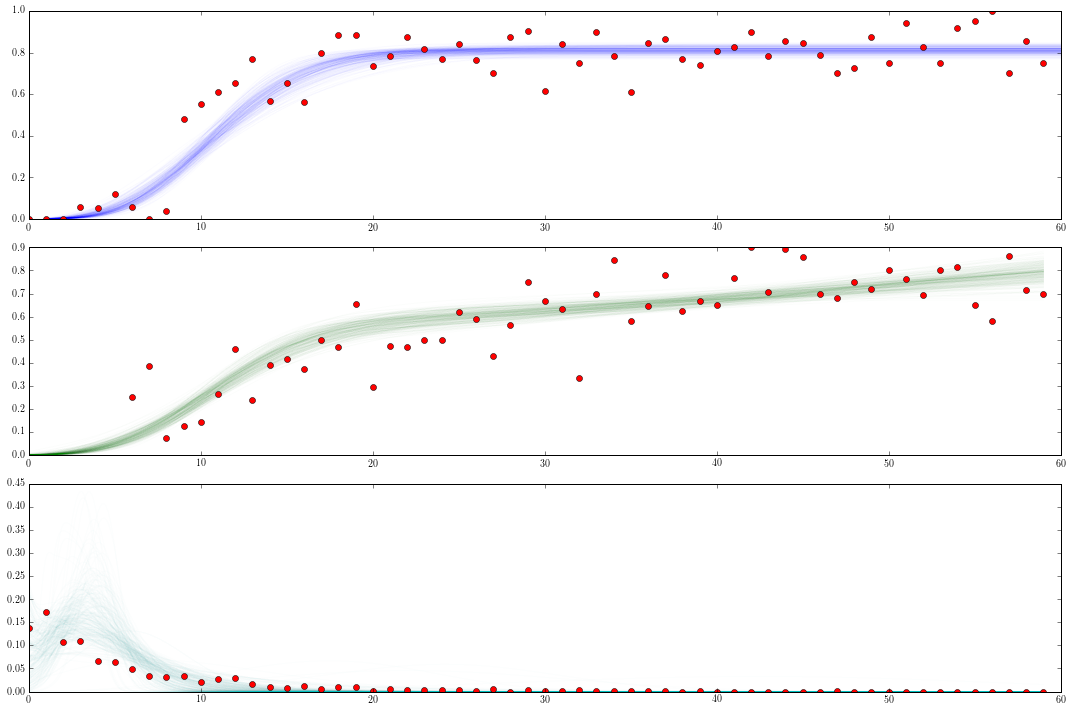

In [145]:
nspace = 500
x = np.linspace(1,60,nspace)
cplot = np.zeros(nspace)
vplot = np.zeros(nspace)
vplot2 = np.zeros(nspace)
splot = np.zeros(nspace)
ctest = np.zeros(nspace)
foi = np.zeros(nspace)
l = len(samples[:,0])
nplot = 300
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
#ax0 = axes
ax0, ax1, ax2 = axes.flatten()
#ax0, ax1 = axes.flatten()
for k in range(nplot):
    index = np.random.randint(l)
    
    valpha = samples[index,0]
    vbeta = samples[index,1]
    vheight = samples[index,2]
    falpha = samples[index,3]
    fbeta = samples[index,4]
    fheight = samples[index,5]
    veff = samples[index,6]
    c = samples[index,7]
    
    va = valpha
    vb = vbeta
    vh = vheight
    ve = veff
    
    fa = falpha
    fb = fbeta
    fh = fheight
    
    
    j = 0
    for i in x:
        a = float(i)
        vplot[j] = 1. - np.exp(-vh*(1. - np.exp(-(a/vb)**va)))
        splot[j] = 1.0 - np.exp(-ve*vh*(1.-np.exp(-(i/vb)**va)) - fh*(1. - np.exp((-(i/fb)**fa))))
        cplot[j] = (1.-np.exp(-(fh*fa/fb*(a*12./fb))**(fa-1.)*np.exp(-(a*12./fb)**fa)))\
        *(np.exp(-ve*vh*(1.-np.exp(-(a*12./vb)**va))-fh*(1.-np.exp(-(a*12./fb)**fa))))
        j += 1
    ax0.plot(x,vplot,alpha=0.01,color='b')
    ax1.plot(x-1,splot,alpha=0.01,color='g',linewidth=1)
    ax2.plot(x-1,cplot/(sum(cplot)*(x[1]-x[0])),alpha=0.01,color='c',linewidth=1)
        
ax0.plot(vobs.astype(float)/vtry.astype(float), 'ro')
ax1.plot(sobs.astype(float)/stry.astype(float),'ro')
ax2.plot(cobs.astype(float)/total_cases,'ro')

plt.xlim(0,60)
fig.tight_layout()
#plt.savefig('SKIVU-nocase.png')